In [349]:
import os
import numpy as np
import pandas as pd
from glob import glob

In [350]:
# model = "UNext"
# model = "CMUNeXt-S"
# model = "TinyUNet"
# model = "XTinyUNet"
# model = "XTinyMonoUNetScale1"
# model = "XTinyMonoUNetScale6"
# model = "XTinyMonoUNetScale1_no_ortho"
# model = "XTinyMonoUNetScale6_no_ortho"
# model = "XTinyMonoV2UNetScale1"
# model = "XTinyMonoV2UNetScale6"
# model = "XTinyMonoV2GatedUNet"
model = "XTinyMonoV2GatedEncUNet"
# model = "XTinyMonoV2GatedEncUNetV0"
# model = "XTinyMonoV2GatedEncDecUNet"
# model = "XTinyMonoUNetgated"
# model = "XTinyMonoUNetgatedenc"
# model = "XTinyMonoUNetgateddec"
# model = "XTinyMonoUNetgatedencdec"
train_dataset = "Dataset073_GE_LE"
model_dir = f"models/{model}/{train_dataset}"

cv_avg_metrics = pd.DataFrame()
for fold in range(5):
    results_csv = f"{model_dir}/fold_{fold}/test/results.csv"
    print(results_csv)
    df = pd.read_csv(results_csv)
    print(df)
    assert len(df) == 4, "len(df) for %s != 4" % results_csv
    cv_avg_metrics = pd.concat([cv_avg_metrics, df])

# Replace inf with NaN so they're both skipped in mean calculation
cv_avg_metrics = cv_avg_metrics.replace([np.inf, -np.inf], np.nan)

cv_avg_metrics = cv_avg_metrics.groupby('test_dataset_name').mean().reset_index()
cv_avg_metrics = cv_avg_metrics.round(2)
cv_avg_metrics = cv_avg_metrics[['test_dataset_name', 'dice', 'masd', 'hd95', 'dice_std', 'masd_std', 'hd95_std']]
cv_avg_metrics = cv_avg_metrics.sort_values(by='dice', ascending=False)
cv_avg_metrics

models/XTinyMonoV2GatedEncUNet/Dataset073_GE_LE/fold_0/test/results.csv
                test_dataset_name   dice  dice_std   hd95  hd95_std  masd  \
0                Dataset073_GE_LE  94.24      1.62   3.00      2.95  0.73   
1              Dataset072_GE_LQP9  94.34      4.12   5.41     16.71  1.24   
2          Dataset070_Clarius_L15  93.52      3.30   5.06     12.34  1.31   
3  Dataset078_KneeUS_OtherDevices  90.10      4.83  25.09     34.78  5.44   

   masd_std  
0      0.30  
1      2.78  
2      2.68  
3      7.12  
models/XTinyMonoV2GatedEncUNet/Dataset073_GE_LE/fold_1/test/results.csv
                test_dataset_name   dice  dice_std   hd95  hd95_std  masd  \
0                Dataset073_GE_LE  94.16      2.42   4.05     11.70  1.09   
1              Dataset072_GE_LQP9  94.40      4.09   4.19     11.77  1.02   
2          Dataset070_Clarius_L15  94.22      2.46   4.62     13.80  1.08   
3  Dataset078_KneeUS_OtherDevices  88.58      4.82  23.93     28.70  3.95   

   masd_std  


,test_dataset_name,dice,masd,hd95,dice_std,masd_std,hd95_std
2,Dataset073_GE_LE,94.27,0.82,2.89,2.11,0.78,4.12
1,Dataset072_GE_LQP9,94.10,1.74,8.94,4.41,3.61,24.20
0,Dataset070_Clarius_L15,93.64,1.18,4.93,2.83,1.73,11.52
3,Dataset078_KneeUS_OtherDevices,88.89,3.71,18.90,6.43,4.85,26.07


Loaded UNext
Loaded CMUNeXt-S
Loaded TinyUNet
Loaded XTinyMonoV2GatedEncUNetV1
Saved comparison plot to results/quantitative/Dataset073_GE_LE_all_models_comparison.png


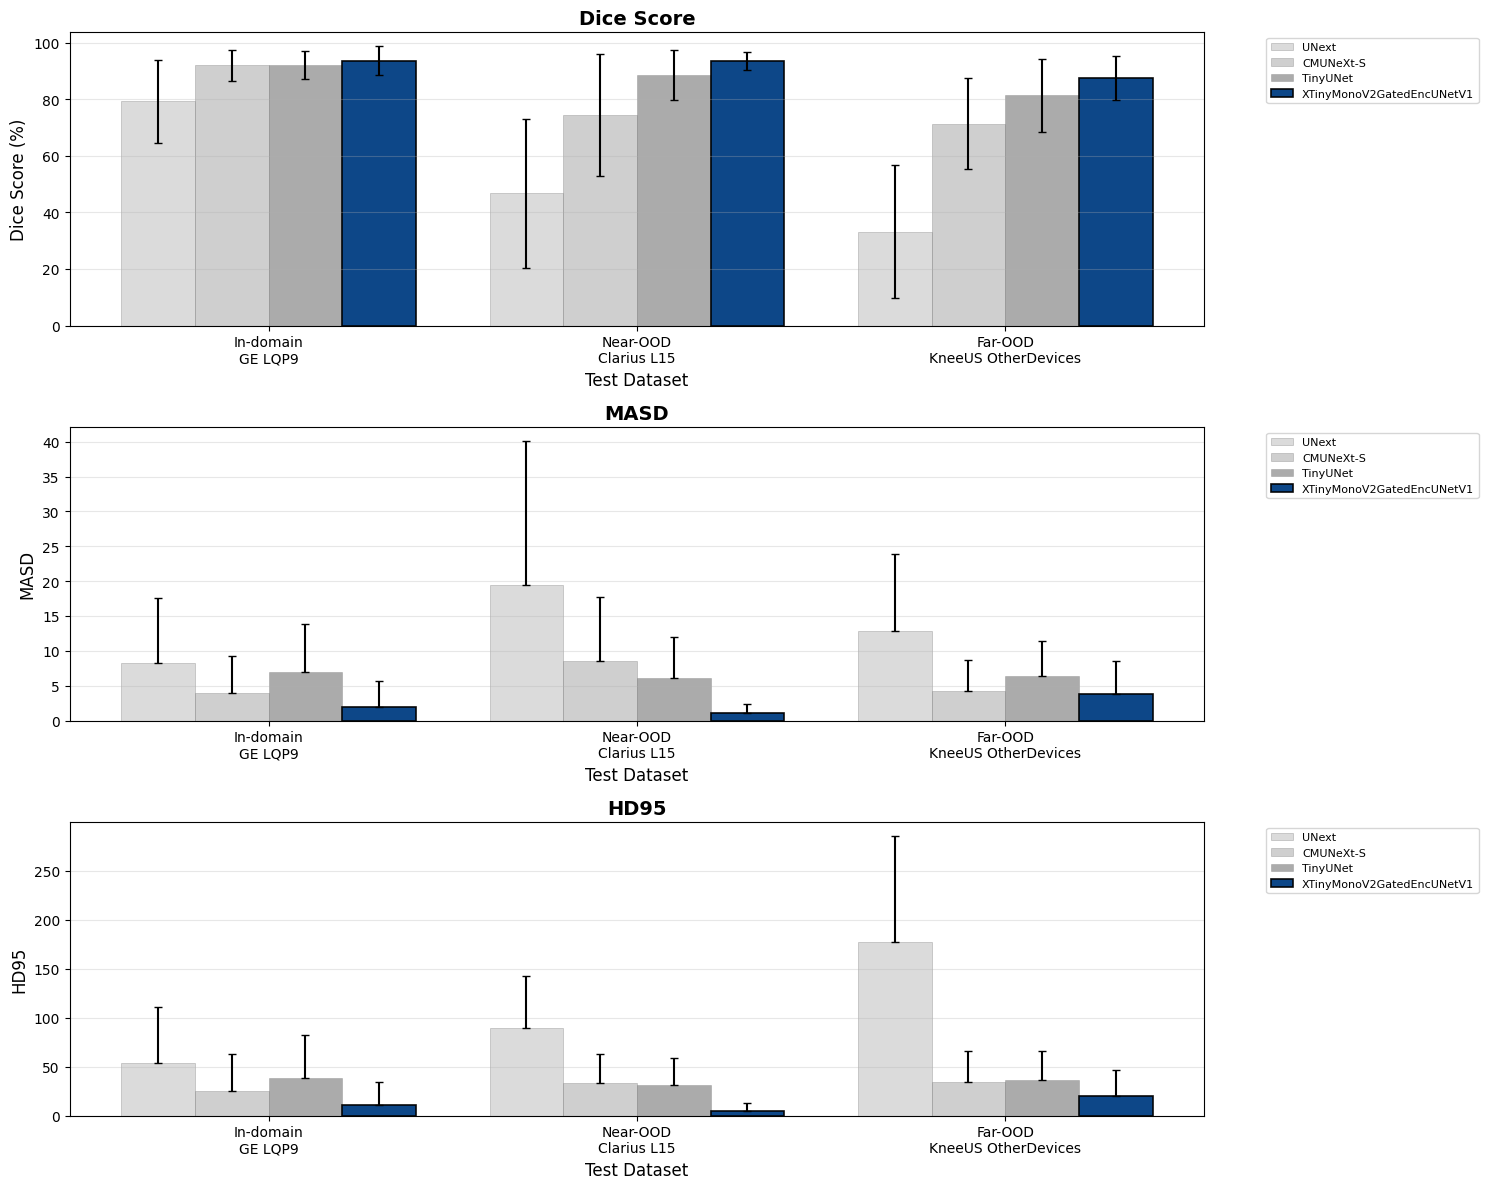

In [351]:
import matplotlib.pyplot as plt

# List of all models to compare
models = [
    "UNext",
    "CMUNeXt-S",
    "TinyUNet", 
    # "XTinyUNet",
    # "XTinyUNetB",
    # "XTinyUNetBDS",
    # "XTinyMonoV2UNetScale1",
    # "XTinyMonoV2UNetScale6",
    # "XTinyMonoV2GatedUNet",
    # "XTinyMonoV2GatedEncUNet",
    # "XTinyMonoV2GatedEncDecUNet",
    "XTinyMonoV2GatedEncUNetV1",
    # "XTinyMonoV2GatedEncUNetV1B",
    # "XTinyMonoV2GatedEncUNetV1DS",
    # "XTinyMonoV2GatedEncDecUNetV1",
    # "XTinyMonoV2GatedDecUNet",
    # "XTinyMonoV2GatedDecUNetV1",
]

# Select train_dataset: "Dataset070_Clarius_L15", "Dataset072_GE_LQP9", or "Dataset073_GE_LE"
train_dataset = "Dataset073_GE_LE"
# train_dataset = "Dataset072_GE_LQP9"
# train_dataset = "Dataset070_Clarius_L15"


# Define dataset mappings
dataset_info = {
    "Dataset070_Clarius_L15": {"name": "Clarius L15", "manufacturer": "Clarius"},
    "Dataset072_GE_LQP9": {"name": "GE LQP9", "manufacturer": "GE"},
    "Dataset073_GE_LE": {"name": "GE LE", "manufacturer": "GE"},
    "Dataset078_KneeUS_OtherDevices": {"name": "KneeUS OtherDevices", "manufacturer": "Other"}
}

# Determine dataset order and labels based on train_dataset
if train_dataset == "Dataset070_Clarius_L15":
    # Training on Clarius L15
    dataset_order = ["Dataset072_GE_LQP9", "Dataset073_GE_LE", "Dataset078_KneeUS_OtherDevices"]
    dataset_labels = [
        f"In-domain\n{dataset_info['Dataset072_GE_LQP9']['name']}",
        f"Near-OOD\n{dataset_info['Dataset073_GE_LE']['name']}",
        f"Far-OOD\n{dataset_info['Dataset078_KneeUS_OtherDevices']['name']}"
    ]
elif train_dataset == "Dataset072_GE_LQP9":
    # Training on GE LQP9
    dataset_order = ["Dataset073_GE_LE", "Dataset070_Clarius_L15", "Dataset078_KneeUS_OtherDevices"]
    dataset_labels = [
        f"In-domain\n{dataset_info['Dataset073_GE_LE']['name']}",
        f"Near-OOD\n{dataset_info['Dataset070_Clarius_L15']['name']}",
        f"Far-OOD\n{dataset_info['Dataset078_KneeUS_OtherDevices']['name']}"
    ]
elif train_dataset == "Dataset073_GE_LE":
    # Training on GE LE
    dataset_order = ["Dataset072_GE_LQP9", "Dataset070_Clarius_L15", "Dataset078_KneeUS_OtherDevices"]
    dataset_labels = [
        f"In-domain\n{dataset_info['Dataset072_GE_LQP9']['name']}",
        f"Near-OOD\n{dataset_info['Dataset070_Clarius_L15']['name']}",
        f"Far-OOD\n{dataset_info['Dataset078_KneeUS_OtherDevices']['name']}"
    ]
else:
    raise ValueError(f"Unknown train_dataset: {train_dataset}")

# Collect data for all models
all_model_data = {}
for model in models:
    model_dir = f"models/{model}/{train_dataset}"
    
    # Check if model directory exists
    if not os.path.exists(model_dir):
        print(f"Skipping {model} - directory not found")
        continue
    
    cv_avg_metrics = pd.DataFrame()
    for fold in range(5):
        results_csv = f"{model_dir}/fold_{fold}/test/results.csv"
        if not os.path.exists(results_csv):
            print(f"Skipping {model} - missing {results_csv}")
            break
        df = pd.read_csv(results_csv)
        if len(df) != 4:
            print(f"Skipping {model} - unexpected df length in {results_csv}")
            break
        cv_avg_metrics = pd.concat([cv_avg_metrics, df])
    else:
        # Replace inf with NaN
        cv_avg_metrics = cv_avg_metrics.replace([np.inf, -np.inf], np.nan)
        cv_avg_metrics = cv_avg_metrics.groupby('test_dataset_name').mean().reset_index()
        cv_avg_metrics = cv_avg_metrics.round(2)
        
        # Reorder by dataset_order
        cv_avg_metrics['test_dataset_name'] = pd.Categorical(
            cv_avg_metrics['test_dataset_name'], 
            categories=dataset_order, 
            ordered=True
        )
        cv_avg_metrics = cv_avg_metrics.sort_values('test_dataset_name')
        
        all_model_data[model] = cv_avg_metrics
        print(f"Loaded {model}")

# Create figure with three subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

metrics = ['dice', 'masd', 'hd95']
metric_labels = ['Dice Score', 'MASD', 'HD95']
metric_y_labels = ['Dice Score (%)', 'MASD', 'HD95']  # Y-axis labels with units

# Define colors: blue shades for Mono models and XTinyUNet, gray gradient for other non-Mono models
def get_model_color(model):
    # XTinyUNet is also blue (user's model) - lightest in the blue gradient
    if model == 'XTinyUNet':
        return '#d6e6ff'  # Very light blue (lighter than Mono models)
    elif 'Mono' not in model:
        # Non-Mono models: gray gradient (light to darker)
        # Order: UNext (lightest) -> TinyUNet (darkest)
        if model == 'UNext':
            return '#B8B8B8'  # Light gray (darker than before)
        elif model == 'TinyUNet':
            return '#585858'  # Dark gray (darker than before)
        else:
            return '#A0A0A0'  # Default gray for other non-Mono models (darker than before)
    else:
        # Mono models: blue shades with varying intensities (darker = more emphasis)
        if 'MonoV2GatedEnc' in model:
            return '#003d82'  # Very dark blue (most emphasis)
        elif 'MonoV2Gated' in model:
            return '#0052a3'  # Dark blue
        elif 'MonoV2UNetScale6' in model:
            return '#0066cc'  # Medium-dark blue
        elif 'MonoV2UNetScale1' in model:
            return '#1a7ae6'  # Medium blue
        elif 'MonoUNetScale6' in model:
            return '#4d94ff'  # Medium-light blue
        elif 'MonoUNetScale1' in model:
            return '#80b3ff'  # Light blue
        else:
            return '#b3d1ff'  # Very light blue for other Mono models

x = np.arange(len(dataset_labels))
width = 0.8 / len(all_model_data)  # Width of bars

for idx, (metric, metric_label, metric_y_label) in enumerate(zip(metrics, metric_labels, metric_y_labels)):
    ax = axes[idx]
    
    # Collect all values to determine best model for each dataset
    all_values = {}  # {dataset_idx: {model: value}}
    
    for i, (model, data) in enumerate(all_model_data.items()):
        values = []
        errors = []
        for dataset_idx, dataset in enumerate(dataset_order):
            row = data[data['test_dataset_name'] == dataset]
            if len(row) > 0:
                value = row[metric].values[0]
                values.append(value)
                errors.append(row[f'{metric}_std'].values[0])
                # Store for best model determination
                if dataset_idx not in all_values:
                    all_values[dataset_idx] = {}
                all_values[dataset_idx][model] = value
            else:
                values.append(np.nan)
                errors.append(0)
        
        offset = (i - len(all_model_data) / 2 + 0.5) * width
        color = get_model_color(model)
        # Emphasize Mono models and XTinyUNet: higher alpha, black edge
        # Non-Mono models: lower alpha, thin gray border
        is_blue_model = 'Mono' in model or model == 'XTinyUNet'
        alpha = 0.95 if is_blue_model else 0.5
        edgecolor = 'black' if is_blue_model else '#808080'  # Black for blue models, gray for others
        linewidth = 1.2 if is_blue_model else 0.5  # Thin border for non-blue models
        
        # For metrics where lower is better (MASD, HD95), error bars should only go upward
        # since these metrics are bounded at 0 (can't be negative)
        if metric in ['masd', 'hd95']:
            # yerr format: [lower_errors, upper_errors] - set lower to 0
            yerr_lower = [0] * len(errors)
            yerr_upper = errors
            yerr = [yerr_lower, yerr_upper]
        else:
            # For Dice (higher is better, bounded at 100), show symmetric error bars
            yerr = errors
        
        ax.bar(x + offset, values, width, yerr=yerr, 
               label=model, color=color, alpha=alpha, capsize=3, 
               edgecolor=edgecolor, linewidth=linewidth)
    

    ax.set_xlabel('Test Dataset', fontsize=12)
    ax.set_ylabel(metric_y_label, fontsize=12)
    ax.set_title(metric_label, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_labels, rotation=0)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Show legend on each subplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f'results/quantitative/{train_dataset}/all_models_comparison.png'
, dpi=150, bbox_inches='tight')
print(f"Saved comparison plot to results/quantitative/{train_dataset}/all_models_comparison.png")
plt.show()


Saved complexity plots (Far-OOD) to results/quantitative/Dataset073_GE_LE_dice_vs_complexity_far_ood.png


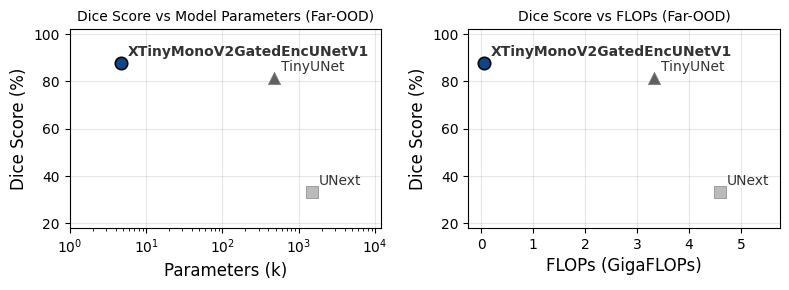

In [352]:
import json
from matplotlib.ticker import MultipleLocator

# Load model analysis data (parameters and FLOPs)
model_analysis_data = {}
for model in models:
    analysis_path = f"models/{model}/model_analysis.json"
    if os.path.exists(analysis_path):
        with open(analysis_path, 'r') as f:
            model_analysis_data[model] = json.load(f)
    else:
        print(f"Warning: Model analysis not found for {model} at {analysis_path}")

# Collect data for scatter plots
plot_data = []
for model in models:
    if model not in all_model_data:
        continue
    if model not in model_analysis_data:
        continue
    
    # Get far-OOD dice score (third dataset in dataset_order)
    far_ood_dataset = dataset_order[2]
    model_data = all_model_data[model]
    row = model_data[model_data['test_dataset_name'] == far_ood_dataset]
    
    if len(row) > 0:
        dice_score = row['dice'].values[0]
        # Use total_millions if > 0, otherwise calculate from total
        params_millions = model_analysis_data[model]['parameters']['total_millions']
        if params_millions == 0.0:
            params_millions = model_analysis_data[model]['parameters']['total'] / 1e6
        flops_giga = model_analysis_data[model]['flops']['giga']
        
        plot_data.append({
            'model': model,
            'dice': dice_score,
            'params_millions': params_millions,
            'flops_giga': flops_giga,
            'color': get_model_color(model)
        })

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Define markers for different models
# Mono models get round markers, others get different shapes
markers = ['s', '^', 'v', 'D', 'p', '*', 'X', 'P', 'h', 'H', '+', 'x', '|', '_']
marker_dict = {}
marker_idx = 0
for data in plot_data:
    if 'Mono' in data['model'] or data['model'] == 'XTinyUNet':
        marker_dict[data['model']] = 'o'  # Round for Mono models
    else:
        marker_dict[data['model']] = markers[marker_idx % len(markers)]
        marker_idx += 1

# Plot 1: Dice vs Parameters
ax1 = axes[0]
for data in plot_data:
    is_blue_model = 'Mono' in data['model'] or data['model'] == 'XTinyUNet'
    alpha = 0.95
    edgecolor = 'black' if is_blue_model else '#808080'
    linewidth = 1.2 if is_blue_model else 0.5
    
    params_thousands = data['params_millions'] * 1000
    ax1.scatter(params_thousands, data['dice'], 
                s=80, color=data['color'], alpha=alpha,
                edgecolor=edgecolor, linewidth=linewidth,
                marker=marker_dict[data['model']], zorder=3)
    
    # Add model name as annotation
    fontweight = 'bold' if 'Mono' in data['model'] or data['model'] == 'XTinyUNet' else 'normal'
    ax1.annotate(data['model'], 
                (params_thousands, data['dice']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, alpha=0.8, weight=fontweight)

ax1.set_xlabel('Parameters (k)', fontsize=12)
ax1.set_ylabel('Dice Score (%)', fontsize=12)
ax1.set_title('Dice Score vs Model Parameters (Far-OOD)', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(MultipleLocator(500))
ax1.set_ylim(18, 102)
ax1.set_xlim(1, 12000)
ax1.set_xscale('log')

# Plot 2: Dice vs FLOPs
ax2 = axes[1]
for data in plot_data:
    is_blue_model = 'Mono' in data['model'] or data['model'] == 'XTinyUNet'
    alpha = 0.95
    edgecolor = 'black' if is_blue_model else '#808080'
    linewidth = 1.2 if is_blue_model else 0.5
    
    ax2.scatter(data['flops_giga'], data['dice'], 
                s=80, color=data['color'], alpha=alpha,
                edgecolor=edgecolor, linewidth=linewidth,
                marker=marker_dict[data['model']], zorder=3)
    
    # Add model name as annotation
    fontweight = 'bold' if 'Mono' in data['model'] or data['model'] == 'XTinyUNet' else 'normal'
    ax2.annotate(data['model'], 
                (data['flops_giga'], data['dice']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, alpha=0.8, weight=fontweight)

ax2.set_xlabel('FLOPs (GigaFLOPs)', fontsize=12)
ax2.set_ylabel('Dice Score (%)', fontsize=12)
ax2.set_title('Dice Score vs FLOPs (Far-OOD)', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(18, 102)
ax2.set_xlim(-0.25, 5.75)


plt.tight_layout()
plt.savefig(f'results/quantitative/{train_dataset}/dice_vs_complexity_far_ood.png', dpi=150, bbox_inches='tight')
print(f"Saved complexity plots (Far-OOD) to results/quantitative/{train_dataset}/dice_vs_complexity_far_ood.png")
plt.show()
